
In this notebook, I will be performing analysis of inpatient discharges for Medicare fee-for-service beneficiaries. approximately 3000 providers(hospitals) are in this dataset. Treatments are classified based on Medicare Severity Diagnosis Related Group(MS-DRG), of which there are 100. The dataset states how much on average each provider bills for the service in a particular MS-DRG , the total payment to the provider, and the medicare portion of the total payment. For additional information to the data source, please refer to the ReadMe.


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import pickle

from matplotlib.cm import get_cmap
from main import truncate_colormap, overlay_map


#matplotlib inline
%matplotlib notebook
pd.options.mode.chained_assignment = None  # default='warn'

<IPython.core.display.Javascript object>


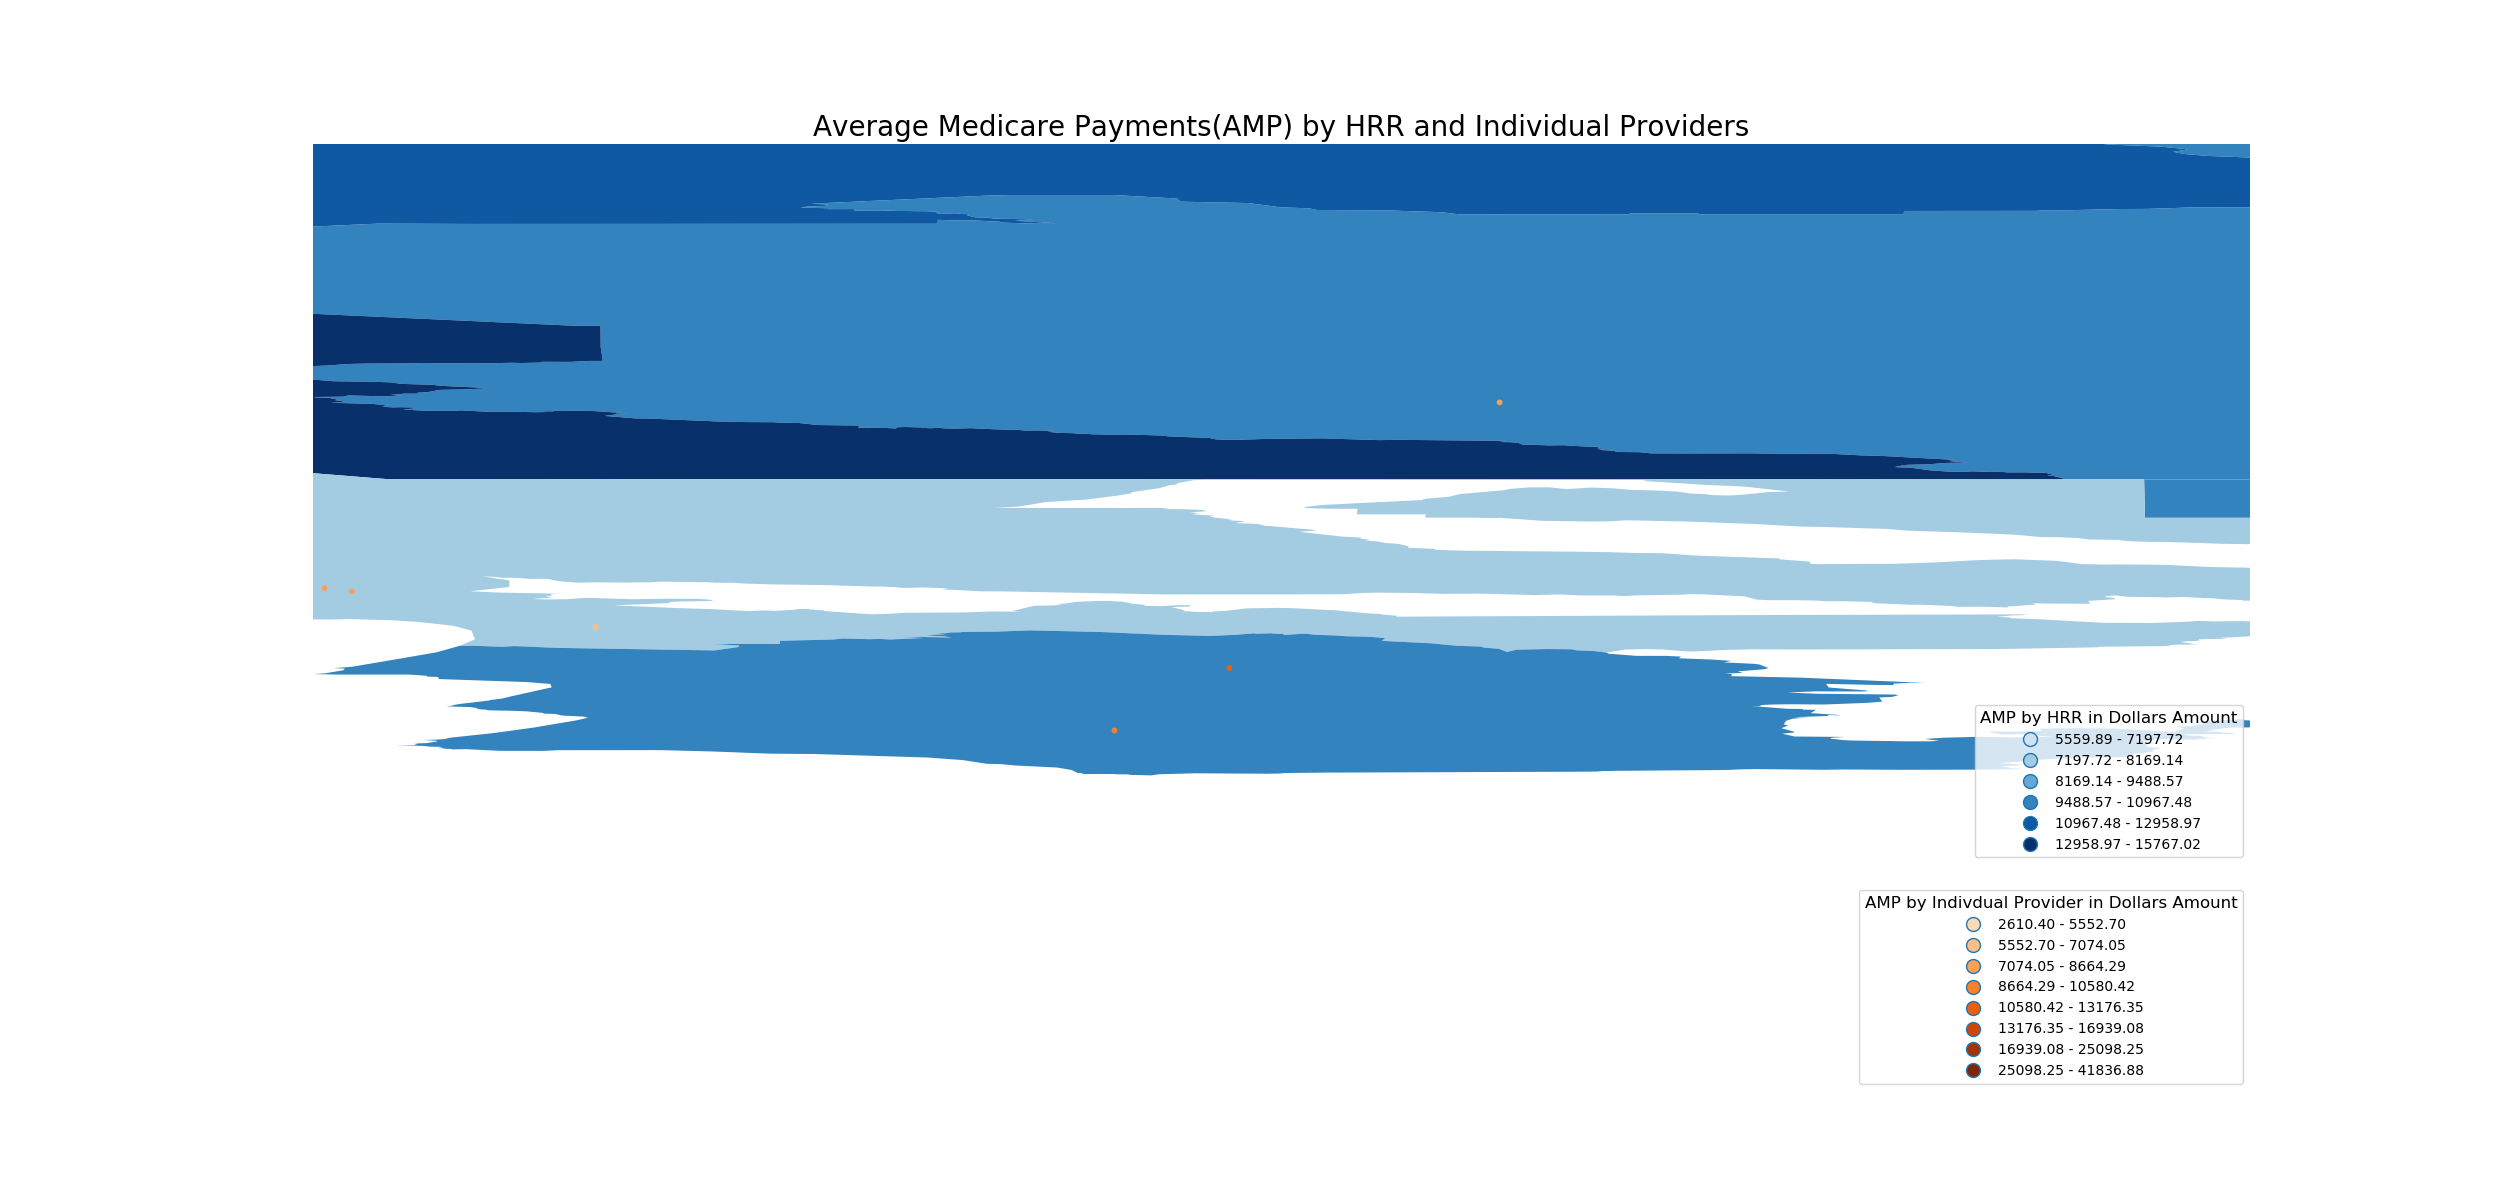

In [3]:
with open('Vis/AMP.pickle', 'rb') as pickle_file:
    test_fig = pickle.load(pickle_file)

I think the dataset provide an interesting opportunity for geographic visualization, where we can see how the cost-structure is different between providers and between regions. I have transformed the dataset into a GeoDataframe, which allows mapping of the data. 

In [ ]:
hrr_gdf = pd.read_pickle('Dataframes/merged_hrr_gdf')
provider_gdf = pd.read_pickle('Dataframes/gdf_medicare_correct_hrr')

The region I referenced earlier is called an Hospital referral region(HRR), which represent regional health care markets for tertiary medical care, each had at least one city where both major cardiovascular surgical procedures and neurosurgery. As you can see HRR serves as a readymade boundary for our purpose of geographic analysis. 


In [ ]:
hrr_gdf.head()

In [ ]:
provider_gdf.head()

A quick note here about the calculations I performed. hrr_gdf's cost data columns are based on the average of all providers for that particular HRR. Provider gdf's data are all specific to that provider. As you can see, there is a column called geometry in both geodataframes, which provides the latitude and longitude, as well as the shape of the object.


In [ ]:
numerical_col = (['Total Discharges', 'Average Covered Charges',
                  'Average Total Payments', 'Average Medicare Payments'])
numerical_dict = dict.fromkeys(numerical_col, 'mean')

In [ ]:
'''aggregating all provider treatment caregories into an average value, drop
duplicate is used because groupby aggregate will keep 
provider groups seperatly'''
provider_agg = provider_gdf.groupby(['Provider Name'],
                                    as_index=False).agg(numerical_dict)
dups = ['Provider Name','geometry', 'HRRD' ]
provider_geo_agg = (provider_gdf[dups].drop_duplicates
                    (subset = ['Provider Name']))

In [ ]:
provider_gdf_agg= provider_geo_agg.merge(provider_agg, on = 'Provider Name')

In [ ]:
provider_gdf_agg.head()

Now we have all the dataframes we needed to plot our maps, which will began by comparing the average covered charges between HRR and providers 

In [ ]:
#The beginning of thesecolorbars are white, making it diffcult to see on maps. 
truncate_blue = truncate_colormap(plt.get_cmap("Blues"), 0.2, 1.0)
truncate_oranges= truncate_colormap(plt.get_cmap("Oranges"), 0.2, 1.0)

In [ ]:
fig_t, ax1 = plt.subplots(1, figsize = (10,4))
ax1.axis('off')
hrr_base =  hrr_gdf.plot(ax = ax1, column='Average Covered Charges',
                         scheme='fisher_jenks', cmap= truncate_blue,
                         legend=True, k =6,
                         label = 'HRR Average Covered Charges') 
hrr_base.get_legend().set_title('ACC by HRR in Dollars Amount',
                                prop={'size':12})
hrr_leg = hrr_base.get_legend()

provider_gdf_agg.plot(ax = hrr_base, column='Average Covered Charges',
                      scheme='fisher_jenks', cmap= truncate_oranges,
                      markersize = 10, legend=True, k =8)
ax1.set_title('Average Covered Charges(ACC) by HRR and Individual Providers',
              fontsize=20)
ax1.get_legend().set_title('ACC by Indivdual Provider in Dollars Amount',
                           prop ={'size': 12})
ax1.add_artist(hrr_leg)
hrr_leg.set_bbox_to_anchor((1, 0.4))
ax1.get_legend().set_bbox_to_anchor((1, 0.2))
ax1.set_xlim([-130, -60])
ax1.set_ylim([23, 52])

Quick rundown of what I did to generate the graph, I first generated a choropleth map from hrr_gdf, which shows the average 
covered charges for each HRR. The set is divided into 6 bucket, with each bucket a different shade of blue. I then overlay another choropleth map based on the provider using the hrr_base as the base graph. 

In [ ]:
g_params = {'bc_name' : 'Average Total Payments', 'oc_name':
            'Average Total Payments',
            'title': 'Average Total Payments(ATP) by HRR and Individual Providers',
           'bl_name':'ATP by HRR in Dollars Amount',
           'ol_name': 'ATP by Indivdual Provider in Dollars Amount'}

In [ ]:
overlay_map(base_gdf = hrr_gdf, overlay_gdf = provider_gdf_agg,
            bc = truncate_blue, oc = truncate_oranges, **g_params)

In [ ]:
m_params = {'bc_name' : 'Average Medicare Payments', 'oc_name':
            'Average Medicare Payments',
            'title': 'Average Medicare Payments(AMP) by HRR and Individual Providers',
           'bl_name':'AMP by HRR in Dollars Amount',
           'ol_name': 'AMP by Indivdual Provider in Dollars Amount'}

In [ ]:
#The map generation function was placed in main 
fig_amp = overlay_map(base_gdf = hrr_gdf, overlay_gdf = provider_gdf_agg,
            bc = truncate_blue, oc = truncate_oranges, **m_params)

with open('Vis/AMP.pickle', 'wb') as pickle_file:
    pickle.dump(fig_amp, pickle_file)



In [ ]:
with open('Vis/AMP.pickle', 'rb') as pickle_file:
    test_fig = pickle.load(pickle_file)